## Percobaan 2

Sobel dan Median

In [1]:
import os
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.metrics import accuracy_score, classification_report
from skimage.feature import graycomatrix, graycoprops
from scipy.stats import entropy
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.metrics import (confusion_matrix, ConfusionMatrixDisplay)
import seaborn as sns


mengimpor library yang digunakan. Pertama, cv2 adalah pustaka OpenCV yang digunakan untuk pemrosesan gambar dan video, sedangkan os digunakan untuk operasi sistem seperti manipulasi path file. library numpy diimpor sebagai np untuk perhitungan numerik yang efisien, sementara matplotlib.pyplot diimpor sebagai plt untuk visualisasi data dalam bentuk grafik. pandas digunakan untuk manipulasi data dan analisis dalam bentuk DataFrame, sedangkan math menyediakan fungsi matematika dasar. skimage.feature.graycomatrix dan skimage.feature.graycoprops yang bagian dari pustaka scikit-image yang digunakan untuk mengekstraksi fitur tekstur dari gambar, khususnya Gray-Level Co-occurrence Matrix (GLCM) dan propertinya. seaborn adalah pustaka visualisasi yang dibangun di atas Matplotlib, yang menyediakan antarmuka tingkat tinggi untuk membuat grafik yang lebih menarik. kemudian Scikit-Learn, beberapa metrik evaluasi seperti confusion_matrix, accuracy_score, precision_score, recall_score, dan f1_score diimpor untuk menilai performa model klasifikasi. SVC (Support Vector Classifier) diimpor untuk membuat model klasifikasi menggunakan metode Support Vector Machines. Selain itu, RandomForestClassifier dari Scikit-Learn juga diimpor untuk membuat model klasifikasi menggunakan algoritma Random Forest, yang menggabungkan beberapa pohon keputusan untuk meningkatkan akurasi prediksi.

## Data Loading

In [2]:
data = []
labels = []
file_name = []

dataset_path = "dataset/"

for sub_folder in os.listdir(dataset_path):
    full_path = os.path.join(dataset_path, sub_folder)

    if not os.path.isdir(full_path):
        continue  # Lewati jika bukan folder

    sub_folder_files = os.listdir(full_path)
    for i, filename in enumerate(sub_folder_files):
        img_path = os.path.join(full_path, filename)
        img = cv.imread(img_path)
        if img is not None:
            img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
            img = cv.resize(img, (256, 256))  # Resize ke ukuran tetap
            img = img.astype(np.uint8)

            data.append(img)
            labels.append(sub_folder)
            name = os.path.splitext(filename)[0]
            file_name.append(filename)

data = np.array(data)
labels = np.array(labels)


Menginisialisasi tiga list kosong yaitu data untuk menyimpan data gambar yang diproses, labels untuk menyimpan label kelas dari setiap gambar, dan file_name untuk menyimpan nama file asli dari setiap gambar. Variabel dataset_path didefinisikan sebagai "dataset/", menunjukkan lokasi root dari dataset gambar. Kemudian, kode ini melakukan iterasi melalui setiap sub-folder yang ada di dalam dataset_path. Untuk setiap item dalam direktori, kode memeriksa apakah itu benar-benar sebuah folder; jika bukan, maka item tersebut dilewati. Jika itu adalah sub-folder, kode akan masuk ke loop kedua untuk membaca setiap file gambar di dalamnya. Setiap file gambar dibaca menggunakan cv.imread, dikonversi menjadi grayscale dengan cv.cvtColor(img, cv.COLOR_BGR2GRAY), diubah ukurannya menjadi (256, 256) menggunakan cv.resize untuk menyeragamkan dimensi, dan diubah tipe datanya menjadi np.uint8. Gambar yang telah diproses ini kemudian ditambahkan ke list data, nama sub-folder ditambahkan ke list labels sebagai label kelas, dan nama file asli ditambahkan ke list file_name. Setelah semua gambar dari semua sub-folder selesai diproses, semua list (data, labels, dan file_name) dikonversi menjadi array NumPy.

## Data Preparation

### Define Preprocessing

Pada Preprocessing akan digunakan 2 buah fungsi untuk mengolah citra yaitu fungsi sobel dan median. Fungsi sobel digunakan untuk melakukan deteksi tepi pada citra skala abu-abu. Fungsi ini mengambil citra gray sebagai masukan, mengubahnya ke tipe data float untuk perhitungan, dan menginisialisasi sebuah array hasil berukuran sama untuk menyimpan citra tepi. Fungsi ini menggunakan dua kernel konvolusi, kernel_x untuk mendeteksi tepi horizontal dan kernel_y untuk mendeteksi tepi vertikal. Dengan melakukan iterasi melalui setiap piksel (kecuali batas tepi), fungsi ini mengekstrak wilayah piksel 3x3 di sekitar piksel saat ini, kemudian menghitung gradien horizontal (gx) dan vertikal (gy) dengan mengalikan wilayah tersebut dengan masing-masing kernel dan menjumlahkannya. Magnitudo gradien (kekuatan tepi) dihitung menggunakan rumus sqrt(gx^2 + gy^2), dan nilai ini ditetapkan sebagai nilai piksel pada citra hasil. Setelah semua piksel diproses, citra hasil dinormalisasi ke rentang 0-255 dan diubah kembali ke tipe np.uint8. Fungsi median dirancang untuk mengurangi noise pada citra menggunakan median filter. Fungsi ini menerima citra masukan (image) serta dimensi kernel (rowkernel dan columnkernel). Pertama, citra asli ditambahkan padding (image_pad) di sekelilingnya dengan mode "edge" untuk menangani piksel di batas citra tanpa menciptakan artefak. Kemudian, fungsi ini mengiterasi setiap piksel dalam citra asli. Untuk setiap piksel, ia mengekstrak submatrix (jendela) yang berpusat pada piksel tersebut dengan ukuran kernel yang ditentukan dari image_pad. Nilai median dari piksel-piksel di dalam submatrix ini kemudian dihitung dan ditetapkan sebagai nilai piksel pada posisi yang sesuai dalam array result.

In [3]:
def thresholding(image, batas):
    hasil = np.copy(image)
    hasil[hasil>=batas] = 255
    hasil[hasil<batas] = 0

    for i in range(hasil.shape[0]):
        for j in range(hasil.shape[1]):
            if(hasil[i][j]==0):
                hasil[i][j]=0
            else:
                hasil[i][j]=255
    return hasil

kernel = np.array([[0, 0, 1, 1, 1],
                   [0, 0, 1, 1, 1],
                   [1, 1, 1, 1, 1],
                   [1, 1, 1, 0, 0],
                   [1, 1, 1, 0, 0]], dtype=np.uint8)

def dilasi(img, kernel):
    img = img.copy()
    pad_h, pad_w = kernel.shape[0] // 2, kernel.shape[1] // 2
    padded = np.pad(img, ((pad_h, pad_h), (pad_w, pad_w)), mode='constant')
    output = np.zeros_like(img)

    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            region = padded[i:i+kernel.shape[0], j:j+kernel.shape[1]]
            if np.any(region[kernel == 1] == 255):
                output[i, j] = 255
    return output


def erosi(img, kernel):
    img = img.copy()
    pad_h, pad_w = kernel.shape[0] // 2, kernel.shape[1] // 2
    padded = np.pad(img, ((pad_h, pad_h), (pad_w, pad_w)), mode='constant')
    output = np.zeros_like(img)

    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            region = padded[i:i+kernel.shape[0], j:j+kernel.shape[1]]
            if np.all(region[kernel == 1] == 255):
                output[i, j] = 255
    return output

def opening(img, kernel):
    return dilasi(erosi(img, kernel), kernel)

def closing(img, kernel):
    return erosi(dilasi(img, kernel), kernel)

## Preprocessing

Fungsi percobaan1 yang bertujuan untuk melakukan preprocessing  citra dengan dua langkah utama: median filtering dan deteksi tepi Sobel. Fungsi percobaan1 mengambil sebuah citra (img) sebagai input. Di dalamnya, citra pertama-tama diolah menggunakan median filter dengan kernel berukuran 3x3 melalui pemanggilan fungsi median(img, 3, 3), yang bertujuan untuk mengurangi noise sambil mempertahankan tepi citra. Hasil dari median filtering ini kemudian menjadi masukan untuk fungsi sobel(imgmed), yang menerapkan operator Sobel untuk mendeteksi tepi pada citra. Hasil akhir dari preprocessing  ini, yaitu citra tepi yang dihasilkan oleh Sobel, dikembalikan oleh fungsi percobaan1. Setelah fungsi percobaan1 didefinisikan, ia diterapkan pada setiap citra dalam list data (yang diasumsikan sudah dimuat sebelumnya), dan hasilnya disimpan dalam list dataPreprocessed. Selanjutnya, kode ini menampilkan contoh citra yang telah melalui preprocessing . Label-label unik dari dataset diurutkan, dan untuk setiap label, sebuah grid gambar berukuran 4x6 dibuat. Setiap subplot dalam grid ini menampilkan citra yang telah diproses dari label tersebut.

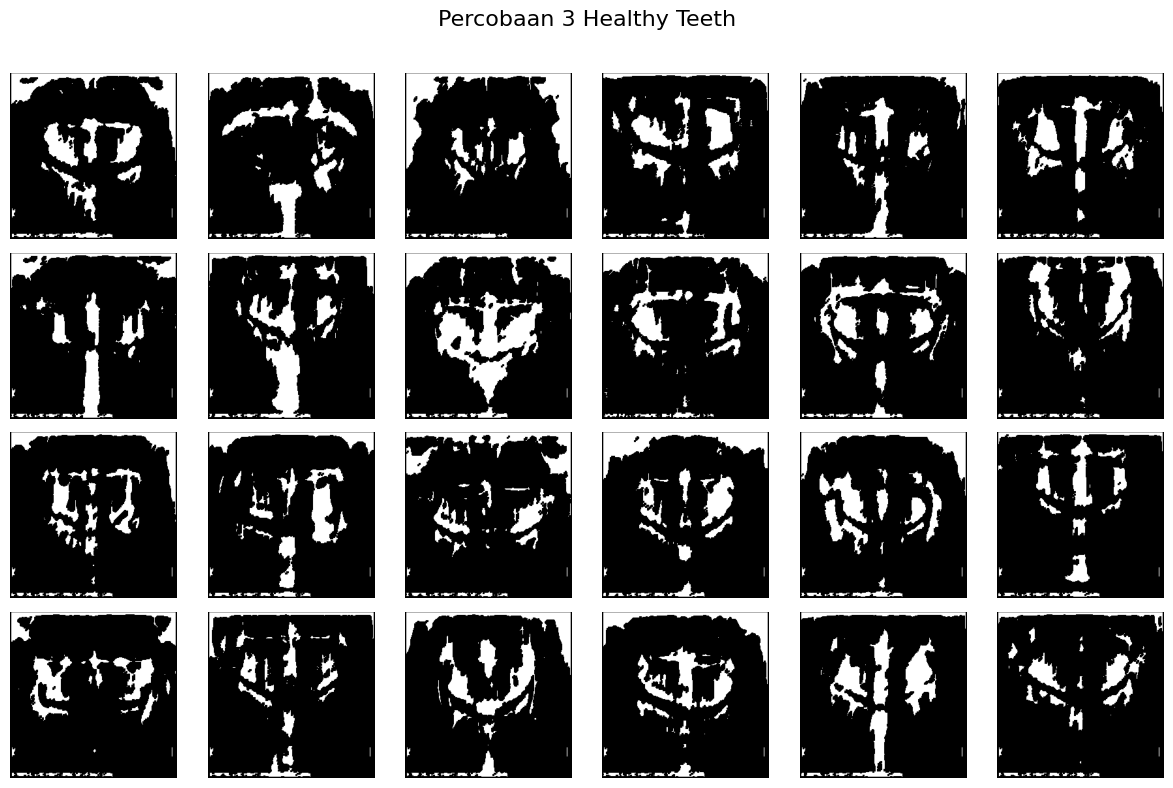

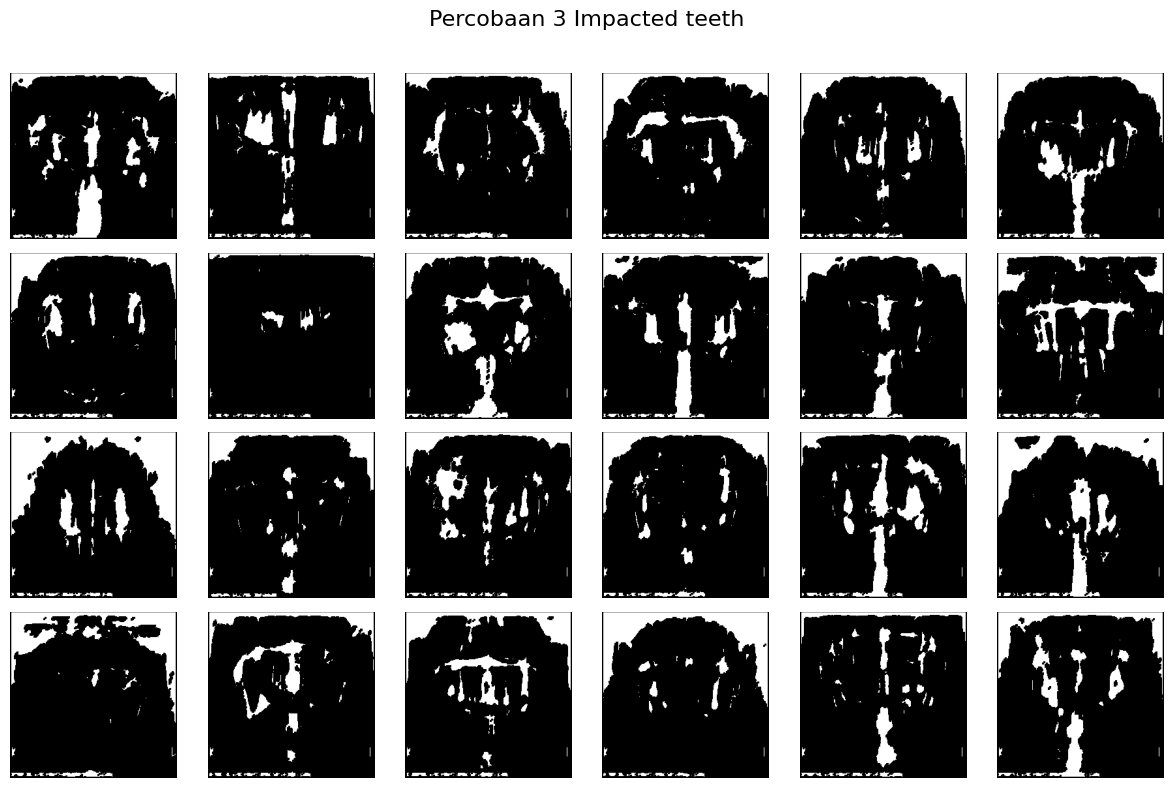

In [4]:
def percobaan1(img):
    imgthr = thresholding(img, 140)
    imgopn = closing(imgthr, kernel)
    return imgopn

dataPreprocessed = [percobaan1(img) for img in data]  

unique_labels = sorted(set(labels))

for label in unique_labels:
    # Ambil semua indeks gambar dari label ini
    idxs = [j for j, l in enumerate(labels) if l == label]
    
    # Buat grid 7x12 (cukup untuk 84 gambar, 7*12 = 84)
    fig, axs = plt.subplots(4, 6, figsize=(12, 8))
    fig.suptitle(f'Percobaan 3 {label}', fontsize=16)
    
    for k in range(24):
        row = k // 6
        col = k % 6
        ax = axs[row][col]
        ax.imshow(dataPreprocessed[idxs[k]], cmap='gray')
        ax.axis('off')

    plt.tight_layout()
    plt.subplots_adjust(top=0.9)  # beri ruang untuk judul
    plt.show()

## Ekstraksi Fitur

In [5]:
def glcm(image, derajat):
    if derajat == 0:
        angles = [0]
    elif derajat == 45:
        angles = [np.pi / 4]
    elif derajat == 90:
        angles = [np.pi / 2]
    elif derajat == 135:
        angles = [3 * np.pi / 4]
    else:
        raise ValueError("Invalid angle. It should be one of the following: 0, 45, 90, 135.")
    
    # mengembalikan matrix glcm dari image
    glcm = graycomatrix(image, [1], angles, 256, symmetric=True, normed=True)
    
    return glcm

Fungsi glcm digunakan untuk menghitung Gray-Level Co-occurrence Matrix (GLCM) dari sebuah citra pada sudut (derajat) tertentu. Fungsi ini mengambil image (citra skala abu-abu) dan derajat (sudut dalam derajat: 0, 45, 90, atau 135). Pertama, fungsi ini memeriksa nilai derajat yang diberikan dan mengkonversinya menjadi nilai radian yang sesuai (0, np.pi / 4, np.pi / 2, atau 3 * np.pi / 4) untuk digunakan oleh fungsi graycomatrix. Jika derajat yang diberikan tidak valid, fungsi akan memunculkan ValueError. Setelah sudut ditentukan, fungsi ini memanggil graycomatrix dari pustaka skimage.feature. graycomatrix menghitung GLCM berdasarkan citra, jarak piksel ([1] yang berarti tetangga langsung), sudut yang telah dikonversi, jumlah level abu-abu (256), serta parameter symmetric=True untuk memastikan GLCM simetris dan normed=True untuk normalisasi.

In [6]:
def correlation(matriks):
	return graycoprops(matriks, 'correlation')[0, 0]

def dissimilarity(matriks):
    return graycoprops(matriks, 'dissimilarity')[0, 0]

def homogenity(matriks):
    return graycoprops(matriks, 'homogeneity')[0, 0]

def contrast(matriks):
    return graycoprops(matriks, 'contrast')[0, 0]

def ASM(matriks):
    return graycoprops(matriks, 'ASM')[0, 0]

def energy(matriks):
    return graycoprops(matriks, 'energy')[0, 0]

def entropyGlcm(matriks):
    return entropy(matriks.ravel())

Mendefinisikan serangkaian fungsi yang bertujuan untuk mengekstrak berbagai properti tekstur dari Gray-Level Co-occurrence Matrix (GLCM) yang telah dihitung sebelumnya, serta entropi dari matriks tersebut. Fungsi-fungsi ini mengambil matriks GLCM sebagai input. Di dalamnya, fungsi correlation(matriks) menghitung properti korelasi yang mengukur linearitas hubungan gray-level antara piksel tetangga. Fungsi dissimilarity(matriks) menghitung ketidakmiripan, yang menunjukkan variasi gray-level di antara piksel tetangga. Selanjutnya, fungsi homogenity(matriks) mengukur seberapa dekat distribusi elemen GLCM dengan diagonal, mencerminkan kehalusan tekstur. Fungsi contrast(matriks) mengukur intensitas perbedaan antara piksel-piksel tetangga. Fungsi ASM(matriks) (Angular Second Moment) menghitung homogenitas dan keteraturan tekstur, sedangkan energy(matriks) adalah akar kuadrat dari ASM yang juga mengukur keteraturan. Terakhir, fungsi entropyGlcm(matriks) menghitung entropi dari GLCM yang diratakan, yang mengukur kompleksitas atau ketidakteraturan tekstur.

Kode ini memulai dengan serangkaian inisialisasi untuk data, labels, dan file_name, yang kemudian diisi melalui iterasi pada sub-folder dalam dataset_path, di mana setiap gambar diubah ke grayscale, di-resize menjadi (256, 256), dan disimpan bersama label dan nama file-nya sebagai array NumPy. Selanjutnya, kode mendefinisikan fungsi percobaan1 yang bertujuan untuk melakukan preprocessing  citra dengan dua langkah utama: median filtering dan deteksi tepi Sobel, di mana citra img pertama-tama diolah menggunakan median filter dengan kernel berukuran 3x3 melalui pemanggilan fungsi median(img, 3, 3) untuk mengurangi noise sambil mempertahankan tepi, dan hasilnya kemudian menjadi masukan untuk fungsi sobel(imgmed) yang menerapkan operator Sobel untuk mendeteksi tepi, dengan hasil akhir berupa citra tepi yang dikembalikan; setelah fungsi ini didefinisikan, ia diterapkan pada setiap citra dalam list data, dan hasilnya disimpan dalam list dataPreprocessed, yang kemudian ditampilkan contoh citranya dalam sebuah grid 4x6 untuk setiap label unik dari dataset, menunjukkan bagaimana percobaan1 mengubah citra asli menjadi representasi tepi yang lebih bersih untuk analisis lebih lanjut. Mengikuti tahap preprocessing  ini, kode mendefinisikan fungsi glcm untuk menghitung Gray-Level Co-occurrence Matrix (GLCM) dari citra pada sudut yang ditentukan (0, 45, 90, atau 135 derajat), dan serangkaian fungsi (correlation, dissimilarity, homogenity, contrast, ASM, energy, entropyGlcm) yang secara individual mengekstrak properti tekstur spesifik dari matriks GLCM yang telah dihitung. Keseluruhan proses ekstraksi fitur ini dikoordinasikan oleh fungsi ekstrak_fitur_glcm, yang mengiterasi melalui list citra yang telah di preprocessing  (data), mengonversi setiap citra ke np.uint8, menghitung GLCM pada 0 derajat menggunakan fungsi glcm, dan kemudian menghitung ketujuh properti tekstur tersebut (kontras, korelasi, energi, homogenitas, ketidakmiripan, ASM, dan entropi), mengumpulkan semuanya dalam sebuah list kamus. List ini kemudian diubah menjadi DataFrame Pandas (df), dengan penambahan kolom 'tahap' untuk identifikasi preprocessing (nama_prepro), dan akhirnya, DataFrame hasil (df2) dari dataPreprocessed ditampilkan.

In [7]:
# Fungsi ekstraksi fitur untuk list citra
def ekstrak_fitur_glcm(data, nama_prepro):
    fitur_list = []
    for img in data:
        img_u8 = img.astype(np.uint8)
        m = glcm(img_u8, 0)  # derajat 0
        
        fitur = {
            'contrast': contrast(m),
            'correlation': correlation(m),
            'energy': energy(m),
            'homogeneity': homogenity(m),
            'dissimilarity': dissimilarity(m),
            'ASM': ASM(m),
            'entropy': entropyGlcm(m)
        }
        fitur_list.append(fitur)

    df = pd.DataFrame(fitur_list)
    df['tahap'] = nama_prepro
    return df

df2 = ekstrak_fitur_glcm(dataPreprocessed, 'percobaan3')
display(df2)

,contrast,correlation,energy,homogeneity,dissimilarity,ASM,entropy,tahap
0,1701.328125,0.913296,0.820216,0.973836,6.671875,0.672754,0.593451,percobaan3
1,1498.125000,0.918773,0.832977,0.976961,5.875000,0.693850,0.560518,percobaan3
2,1836.796875,0.907736,0.816328,0.971753,7.203125,0.666391,0.605708,percobaan3
3,1549.921875,0.900885,0.858048,0.976165,6.078125,0.736246,0.508139,percobaan3
4,1520.039062,0.893506,0.870438,0.976624,5.960938,0.757662,0.478669,percobaan3
...,...,...,...,...,...,...,...,...
209,1502.109375,0.901073,0.862510,0.976900,5.890625,0.743923,0.496491,percobaan3
210,1619.648438,0.915794,0.824568,0.975092,6.351562,0.679913,0.581914,percobaan3
211,1502.109375,0.888519,0.877621,0.976900,5.890625,0.770219,0.460989,percobaan3
212,1749.140625,0.884226,0.861092,0.973101,6.859375,0.741479,0.507297,percobaan3


In [8]:
Derajat0 = []
Derajat45 = []
Derajat90 = []
Derajat135 = []
for i in range(len(dataPreprocessed)):
    D0 = glcm(dataPreprocessed[i], 0)
    D45 = glcm(dataPreprocessed[i], 45)
    D90 = glcm(dataPreprocessed[i], 90)
    D135 = glcm(dataPreprocessed[i], 135)
    Derajat0.append(D0)
    Derajat45.append(D45)
    Derajat90.append(D90)
    Derajat135.append(D135)

Kontras0, Kontras45, Kontras90, Kontras135 = [], [], [], []
dissimilarity0, dissimilarity45, dissimilarity90, dissimilarity135 =  [], [], [], []
homogenity0, homogenity45, homogenity90, homogenity135 = [], [], [], []
entropy0, entropy45, entropy90, entropy135 =  [], [], [], []
ASM0, ASM45, ASM90, ASM135 =  [], [], [], []
energy0, energy45, energy90, energy135 =  [], [], [], []
correlation0, correlation45, correlation90, correlation135 = [], [], [], []

for i in range(len(dataPreprocessed)):
    C0 = correlation(Derajat0[i])
    correlation0.append(C0)
    C45 = correlation(Derajat45[i])
    correlation45.append(C45)
    C90 = correlation(Derajat90[i])
    correlation90.append(C90)
    C135 = correlation(Derajat135[i])
    correlation135.append(C135)

for i in range(len(data)):
    K0 = contrast(Derajat0[i])
    K45 = contrast(Derajat45[i])
    K90 = contrast(Derajat90[i])
    K135 = contrast(Derajat135[i])
    Kontras0.append(K0)
    Kontras45.append(K45)
    Kontras90.append(K90)
    Kontras135.append(K135)

for i in range(len(data)):
    Dis0 = dissimilarity(Derajat0[i])
    Dis45 = dissimilarity(Derajat45[i])
    Dis90 = dissimilarity(Derajat90[i])
    Dis135 = dissimilarity(Derajat135[i])
    dissimilarity0.append(Dis0)
    dissimilarity45.append(Dis45)
    dissimilarity90.append(Dis90)
    dissimilarity135.append(Dis135)

for i in range(len(data)):
    H0 = homogenity(Derajat0[i])
    H45 = homogenity(Derajat45[i])
    H90 = homogenity(Derajat90[i])
    H135 = homogenity(Derajat135[i])
    homogenity0.append(H0)
    homogenity45.append(H45)
    homogenity90.append(H90)
    homogenity135.append(H135)

for i in range(len(data)):  
    E0 = entropyGlcm(Derajat0[i])
    E45 = entropyGlcm(Derajat45[i])
    E90 = entropyGlcm(Derajat90[i])
    E135 = entropyGlcm(Derajat135[i])
    entropy0.append(E0)
    entropy45.append(E45)
    entropy90.append(E90)
    entropy135.append(E135)

for i in range(len(data)):
    A0 = ASM(Derajat0[i])
    A45 = ASM(Derajat45[i])
    A90 = ASM(Derajat90[i])
    A135 = ASM(Derajat135[i])
    ASM0.append(A0)
    ASM45.append(A45)
    ASM90.append(A90)
    ASM135.append(A135)

for i in range(len(data)):
    ER0 = energy(Derajat0[i])
    ER45 = energy(Derajat45[i])
    ER90 = energy(Derajat90[i])
    ER135 = energy(Derajat135[i])
    energy0.append(ER0)
    energy45.append(ER45)
    energy90.append(ER90)
    energy135.append(ER135)



Menginisialisasi empat list kosong: Derajat0, Derajat45, Derajat90, dan Derajat135. Dalam loop pertama, untuk setiap citra dalam dataPreprocessed, fungsi glcm dipanggil empat kali untuk menghitung matriks GLCM pada sudut 0, 45, 90, dan 135 derajat, dan hasilnya masing-masing ditambahkan ke list Derajat0 hingga Derajat135. Setelah matriks GLCM untuk semua sudut telah dihitung, kode menginisialisasi berbagai list kosong lainnya untuk menyimpan properti tekstur yang diekstraksi, seperti Kontras0 hingga Kontras135, dissimilarity0 hingga dissimilarity135, dan seterusnya untuk homogenitas, entropi, ASM, energi, dan korelasi, yang mencerminkan fitur-fitur yang akan diekstraksi untuk setiap orientasi. Kemudian, serangkaian loop terpisah dieksekusi. Setiap loop ini mengiterasi dataPreprocessed (atau secara implisit melalui indeks yang sama dengan DerajatX list), dan untuk setiap citra, ia memanggil fungsi ekstraksi properti GLCM yang spesifik (seperti correlation, contrast, dissimilarity, homogenity, entropyGlcm, ASM, dan energy) pada matriks GLCM yang sesuai untuk setiap sudut (0, 45, 90, 135 derajat). Hasil dari setiap perhitungan properti kemudian ditambahkan ke list fitur yang relevan, misalnya Kontras0.append(K0) untuk kontras pada 0 derajat. 

## Hasil Ekstraksi to CSV

In [9]:
features = []

for i in range(len(dataPreprocessed)):
    fitur = [
        contrast(Derajat0[i]), contrast(Derajat45[i]), contrast(Derajat90[i]), contrast(Derajat135[i]),
        dissimilarity(Derajat0[i]), dissimilarity(Derajat45[i]), dissimilarity(Derajat90[i]), dissimilarity(Derajat135[i]),
        homogenity(Derajat0[i]), homogenity(Derajat45[i]), homogenity(Derajat90[i]), homogenity(Derajat135[i]),
        entropyGlcm(Derajat0[i]), entropyGlcm(Derajat45[i]), entropyGlcm(Derajat90[i]), entropyGlcm(Derajat135[i]),
        ASM(Derajat0[i]), ASM(Derajat45[i]), ASM(Derajat90[i]), ASM(Derajat135[i]),
        energy(Derajat0[i]), energy(Derajat45[i]), energy(Derajat90[i]), energy(Derajat135[i]),
        correlation(Derajat0[i]), correlation(Derajat45[i]), correlation(Derajat90[i]), correlation(Derajat135[i]),
    ]
    features.append(fitur)

# Buat dataframe
columns = [
    "contrast_0", "contrast_45", "contrast_90", "contrast_135",
    "dissimilarity_0", "dissimilarity_45", "dissimilarity_90", "dissimilarity_135",
    "homogeneity_0", "homogeneity_45", "homogeneity_90", "homogeneity_135",
    "entropy_0", "entropy_45", "entropy_90", "entropy_135",
    "ASM_0", "ASM_45", "ASM_90", "ASM_135",
    "energy_0", "energy_45", "energy_90", "energy_135",
    "correlation_0", "correlation_45", "correlation_90", "correlation_135"
]

df_fitur = pd.DataFrame(features, columns=columns)


Kode ini melanjutkan proses ekstraksi fitur dengan menggabungkan semua properti tekstur GLCM yang telah dihitung untuk berbagai sudut ke dalam satu struktur data tunggal yang terorganisir. Pertama, sebuah list kosong bernama features diinisialisasi untuk menyimpan semua fitur yang diekstraksi dari setiap gambar. Kemudian, kode ini melakukan iterasi untuk setiap citra dalam dataPreprocessed. Dalam setiap iterasi, sebuah list fitur dibangun yang secara berurutan berisi nilai-nilai kontras, ketidakmiripan, homogenitas, entropi, ASM, energi, dan korelasi, masing-masing untuk keempat sudut GLCM (0, 45, 90, dan 135 derajat) yang telah dihitung sebelumnya dari Derajat0 hingga Derajat135. List fitur yang lengkap ini kemudian ditambahkan ke list features. Setelah loop selesai, list features akan berisi sub-list untuk setiap gambar, di mana setiap sub-list mewakili semua properti tekstur GLCM pada berbagai sudut. Selanjutnya, sebuah list columns didefinisikan secara eksplisit, berisi nama-nama kolom yang deskriptif (misalnya, "contrast_0", "dissimilarity_45", dll.) untuk mengidentifikasi setiap fitur berdasarkan jenis properti dan sudutnya. Akhirnya, sebuah DataFrame Pandas bernama df_fitur dibuat dari list features menggunakan pd.DataFrame(), dengan list columns yang telah didefinisikan diterapkan untuk memberi label pada kolom-kolom DataFrame.

Kode ini bertujuan untuk menggabungkan semua fitur tekstur GLCM yang telah diekstraksi bersama dengan nama file dan label ke dalam sebuah DataFrame Pandas, kemudian menyimpannya ke dalam file CSV, dan terakhir membacanya kembali untuk ditampilkan. Pertama, sebuah kamus bernama dataTable dibuat. Kamus ini memetakan nama kolom DataFrame (seperti 'Filename', 'Label', 'Contrast0', 'Homogeneity0', dan seterusnya untuk semua fitur GLCM pada semua sudut) ke list data yang sesuai (misalnya, file_name, labels, Kontras0, homogenity0, dll.) yang telah dihasilkan pada langkah sebelumnya. Setelah dataTable selesai dibangun, sebuah DataFrame Pandas bernama df dibuat dari kamus ini menggunakan pd.DataFrame(dataTable), secara efektif menggabungkan semua data fitur yang diekstraksi ke dalam format tabel yang terstruktur. Selanjutnya, DataFrame df ini disimpan ke dalam file CSV dengan nama hasil_ekstraksi_percobaan1.csv menggunakan metode df.to_csv(), dengan parameter index=False untuk mencegah penulisan indeks DataFrame sebagai kolom di file CSV. Sebagai langkah terakhir, kode ini membaca kembali file CSV yang baru saja disimpan ke dalam sebuah DataFrame baru bernama hasilEkstrak menggunakan pd.read_csv(), dan kemudian DataFrame hasilEkstrak ini ditampilkan.

In [10]:
dataTable = {'Filename': file_name, 'Label': labels,
        'Contrast0': Kontras0, 'Contrast45': Kontras45, 'Contrast90': Kontras90, 'Contrast135': Kontras135,
        'Homogeneity0': homogenity0, 'Homogeneity45': homogenity45, 'Homogeneity90': homogenity90, 'Homogeneity135': homogenity135,
        'Dissimilarity0': dissimilarity0, 'Dissimilarity45': dissimilarity45, 'Dissimilarity90': dissimilarity90, 'Dissimilarity135': dissimilarity135,
        'Entropy0': entropy0, 'Entropy45': entropy45, 'Entropy90': entropy90, 'Entropy135': entropy135,
        'ASM0': ASM0, 'ASM45': ASM45, 'ASM90': ASM90, 'ASM135': ASM135,
        'Energy0': energy0, 'Energy45': energy45, 'Energy90': energy90, 'Energy135': energy135,
        'Correlation0': correlation0, 'Correlation45': correlation45, 'Correlation90': correlation90, 'Correlation135': correlation135,
        }
df = pd.DataFrame(dataTable)
df.to_csv('hasil_ekstraksi_percobaan3.csv', index=False)

hasilEkstrak = pd.read_csv('hasil_ekstraksi_percobaan3.csv')
hasilEkstrak


,Filename,Label,Contrast0,Contrast45,Contrast90,Contrast135,Homogeneity0,Homogeneity45,Homogeneity90,Homogeneity135,...,ASM90,ASM135,Energy0,Energy45,Energy90,Energy135,Correlation0,Correlation45,Correlation90,Correlation135
0,102.jpg,Healthy Teeth,1701.328125,2784.0,1755.117188,2746.0,0.973836,0.957186,0.973009,0.957771,...,0.671971,0.656874,0.820216,0.810148,0.819738,0.810478,0.913296,0.858549,0.910555,0.860480
1,104.jpg,Healthy Teeth,1498.125000,2504.0,1587.773438,2398.0,0.976961,0.961492,0.975582,0.963122,...,0.692537,0.679959,0.832977,0.823682,0.832188,0.824596,0.918773,0.864657,0.913913,0.870386
2,108.jpg,Healthy Teeth,1836.796875,2714.0,1438.359375,2578.0,0.971753,0.958263,0.977880,0.960354,...,0.672210,0.654846,0.816328,0.808038,0.819884,0.809226,0.907736,0.864081,0.927750,0.870892
3,110.jpg,Healthy Teeth,1549.921875,2600.0,1701.328125,2592.0,0.976165,0.960016,0.973836,0.960139,...,0.734034,0.720451,0.858048,0.848727,0.856758,0.848794,0.900885,0.834278,0.891203,0.834788
4,111.jpg,Healthy Teeth,1520.039062,2418.0,1366.640625,2296.0,0.976624,0.962815,0.978983,0.964691,...,0.759917,0.745693,0.870438,0.862527,0.871732,0.863535,0.893506,0.831162,0.904253,0.839680
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
209,91.jpg,Impacted teeth,1502.109375,2268.0,1233.164062,2226.0,0.976900,0.965122,0.981036,0.965768,...,0.747885,0.732657,0.862510,0.855602,0.864804,0.855954,0.901073,0.851124,0.918785,0.853881
210,94.jpg,Impacted teeth,1619.648438,2462.0,1350.703125,2350.0,0.975092,0.962138,0.979228,0.963861,...,0.683860,0.668463,0.824568,0.816620,0.826958,0.817596,0.915794,0.872390,0.929777,0.878195
211,96.jpg,Impacted teeth,1502.109375,2466.0,1440.351562,2348.0,0.976900,0.962077,0.977850,0.963891,...,0.771126,0.757277,0.877621,0.869250,0.878138,0.870216,0.888519,0.817602,0.893102,0.826330
212,97.jpg,Impacted teeth,1749.140625,2724.0,1543.945312,2678.0,0.973101,0.958109,0.976256,0.958816,...,0.744475,0.727397,0.861092,0.852495,0.862829,0.852876,0.884226,0.820296,0.897808,0.823331


## Feature Selection

### Correlation

Kode ini digunakan untuk analisis data dengan menghitung korelasi antar fitur dan melakukan seleksi fitur berdasarkan nilai korelasi. Pertama, DataFrame hasilEkstrak dihilangkan kolom 'Label' dan 'Filename' yang non-numerik, dan kemudian metode .corr() dipanggil untuk menghitung matriks korelasi antar semua fitur yang tersisa, hasilnya disimpan dalam variabel correlation. Selanjutnya, kode ini melakukan seleksi fitur untuk mengurangi redundansi dengan mengidentifikasi fitur-fitur yang sangat berkorelasi satu sama lain. Sebuah threshold (ambang batas) ditetapkan, yang diatur ke 0.95, untuk menentukan seberapa tinggi korelasi yang dianggap sebagai redundan. Sebuah array boolean columns diinisialisasi sebagai True untuk semua fitur. Kemudian, dua loop bersarang digunakan untuk mengiterasi matriks correlation. Jika ditemukan sepasang fitur (i dan j) yang memiliki korelasi absolut lebih besar atau sama dengan threshold, dan fitur j belum ditandai untuk dihapus (columns[j] adalah True), maka fitur j ditandai sebagai False dalam array columns, yang berarti fitur tersebut akan dihapus. Setelah loop selesai, list select dibuat yang hanya berisi nama-nama kolom fitur yang tetap True dalam array columns (yaitu, fitur-fitur yang tidak memiliki korelasi tinggi dengan fitur lain). Kemudian, DataFrame baru x_new dibuat dari hasilEkstrak yang hanya berisi fitur-fitur yang telah dipilih ini. Kolom 'Label' dari hasilEkstrak juga disimpan ke variabel y untuk digunakan sebagai target dalam pelatihan model. Terakhir, untuk memvisualisasikan korelasi antar fitur yang tersisa setelah seleksi, sebuah heatmap ditampilkan menggunakan seaborn.heatmap(). Ukuran figure diatur menjadi 17x17, dan x_new.corr() digunakan sebagai data input untuk heatmap, dengan annot=True untuk menampilkan nilai korelasi pada peta panas, cmap='Blues' untuk skema warna, dan fmt=".2f" untuk memformat nilai korelasi menjadi dua angka desimal

<Axes: >

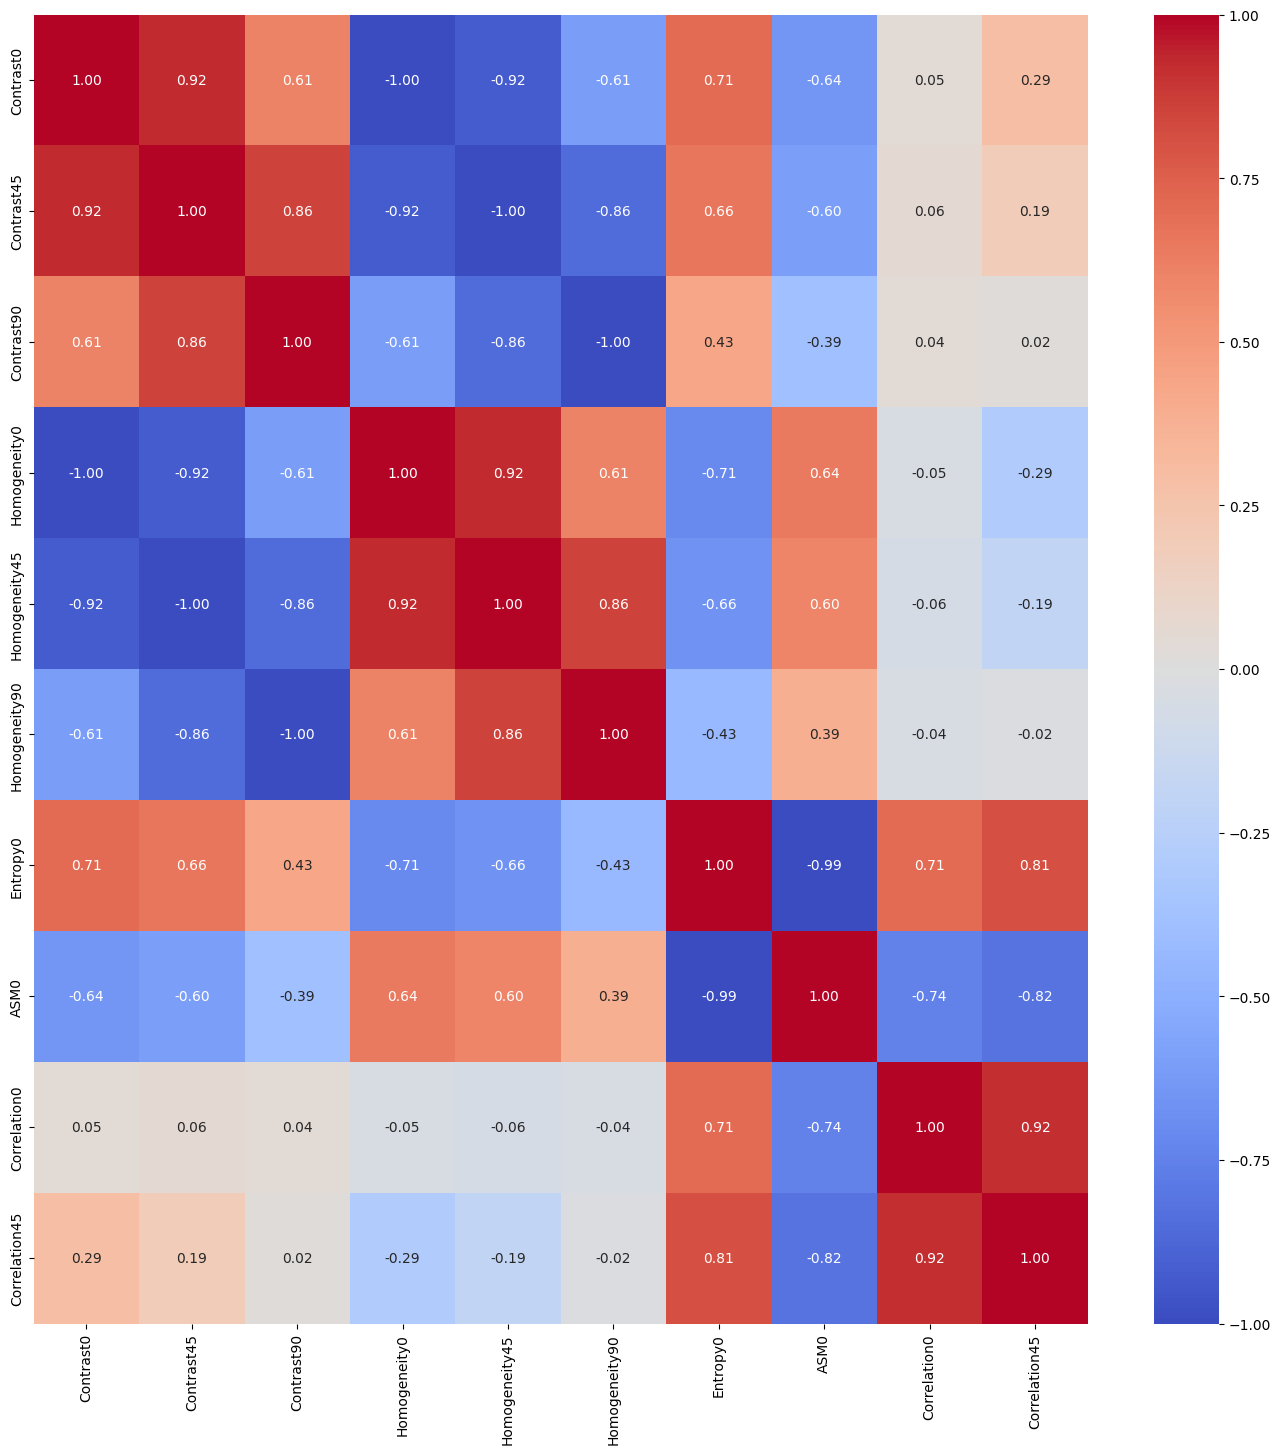

In [11]:
# Menghitung korelasi
correlation = hasilEkstrak.drop(columns=['Label','Filename']).corr()

# Menyaring fitur yang memiliki korelasi absolut lebih dari 0.95 dengan label
threshold = 0.95 # atur threshold ini untuk menentukan seberapa besar korelasi yang ingin disaring
selectionFeature = []
columns = np.full((correlation.shape[0],), True, dtype=bool)
for i in range(correlation.shape[0]):
	for j in range(i+1, correlation.shape[0]):
		if correlation.iloc[i,j] >= threshold:
			if columns[j]:
				columns[j] = False
select = hasilEkstrak.drop(columns=['Label','Filename']).columns[columns]
x_new = hasilEkstrak[select]
x_new
y = hasilEkstrak['Label']
plt.figure(figsize=(17,17))
sns.heatmap(x_new.corr(), annot=True, cmap='coolwarm', fmt=".2f")

### LDA

Kode ini menggunakan Linear Discriminant Analysis (LDA) untuk reduksi dimensi dan visualisasi data fitur. Pertama, library LinearDiscriminantAnalysis diimpor dari sklearn.discriminant_analysis. Kemudian, kode ini mendefinisikan fungsi feature_reduction_lda yang bertujuan untuk melakukan reduksi dimensi menggunakan LDA. Fungsi ini mengambil sebuah dataframe (yang berisi fitur dan label, seperti hasilEkstrak) dan n_components (jumlah dimensi yang diinginkan setelah reduksi, default 2). Di dalam fungsi, kolom 'Label' dan 'Filename' dihilangkan dari DataFrame untuk mendapatkan fitur, sementara kolom 'Label' disimpan sebagai label. Sebuah objek LinearDiscriminantAnalysis diinisialisasi dengan n_components yang ditentukan, kemudian metode fit_transform dipanggil pada fitur dan label untuk melatih model LDA dan mentransformasi data ke ruang dimensi yang lebih rendah (x_lda). Hasil transformasi ini kemudian diubah menjadi DataFrame baru df_lda, dengan nama kolom yang dinamis (misalnya, 'LD1', 'LD2'), dan kolom 'Label' asli ditambahkan kembali ke DataFrame ini. DataFrame df_lda yang berisi data fitur tereduksi ini kemudian dikembalikan oleh fungsi. Setelah fungsi feature_reduction_lda didefinisikan, ia dipanggil dengan hasilEkstrak sebagai DataFrame input dan n_components=2, dan hasilnya disimpan dalam variabel lda_df. Terakhir, kode ini memvisualisasikan hasil proyeksi LDA menggunakan matplotlib.pyplot dan seaborn.scatterplot(). Sebuah figure berukuran 10x6 dibuat, dan scatterplot digambar dengan 'LD1' pada sumbu X dan 'LD2' pada sumbu Y, di mana titik-titik diwarnai berdasarkan 'Label' (hue='Label') menggunakan palet 'Set1'

In [12]:
# # Selection LDA

# from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

# def feature_reduction_lda(dataframe, n_components=2):
#     fitur = dataframe.drop(columns=['Label', 'Filename'])
#     label = dataframe['Label']
    
#     lda = LinearDiscriminantAnalysis(n_components=n_components)
#     x_lda = lda.fit_transform(fitur, label)
    
#     columns = [f'LD{i+1}' for i in range(n_components)]
#     df_lda = pd.DataFrame(x_lda, columns=columns)
#     df_lda['Label'] = label.values
    
#     return df_lda

# lda_df = feature_reduction_lda(hasilEkstrak, n_components=2)

# plt.figure(figsize=(10, 6))
# sns.scatterplot(data=lda_df, x='LD1', y='LD2', hue='Label', palette='Set1')
# plt.title('LDA Projection of Features')
# plt.xlabel('LD1')
# plt.ylabel('LD2')
# plt.legend(title='Label')
# plt.show()

### t-SNE

Kode ini menggunakan teknik reduksi dimensi t-Distributed Stochastic Neighbor Embedding (t-SNE) untuk memvisualisasikan struktur data fitur. Pertama, library TSNE diimpor dari sklearn.manifold. Kemudian, sebuah objek TSNE diinisialisasi dengan parameter n_components=2 (untuk mereduksi data menjadi dua dimensi), perplexity=30, n_iter=1000 (jumlah iterasi maksimum), dan random_state=42 untuk reproduktifitas. Objek tsne ini kemudian dipanggil metode fit_transform() pada DataFrame fitur yang telah diseleksi sebelumnya, x_new, dan hasilnya disimpan dalam X_tsne, yang merupakan array NumPy berisi data yang telah tereduksi dimensinya. Setelah transformasi, sebuah DataFrame baru bernama df_tsne dibuat. Kolom 'Dimensi-1' diisi dengan komponen pertama dari X_tsne, dan kolom 'Dimensi-2' diisi dengan komponen kedua. Kolom 'Label' dari y (label asli) juga ditambahkan ke df_tsne untuk keperluan visualisasi. Terakhir, kode ini memvisualisasikan hasil t-SNE menggunakan matplotlib.pyplot dan seaborn.scatterplot(). Sebuah figure berukuran 10x8 disiapkan, dan scatterplot digambar dengan 'Dimensi-1' pada sumbu X dan 'Dimensi-2' pada sumbu Y, di mana titik-titik diwarnai berdasarkan 'Label' (hue='Label') menggunakan palet 'Set2' dan ukuran titik (s=100). 

C:\Users\yoga7.RAKASYA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


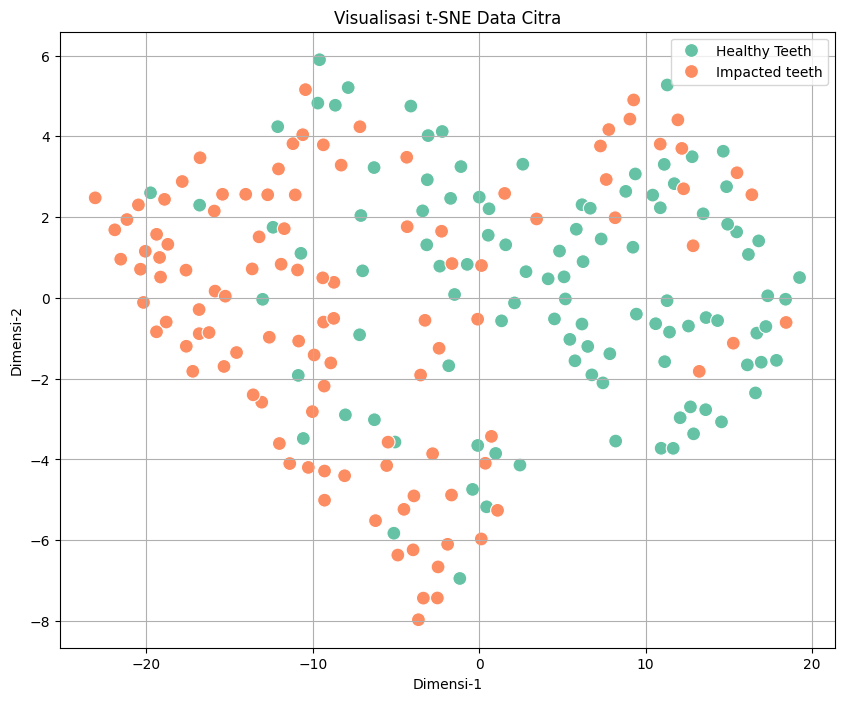

In [13]:
# Selection t-SNE

from sklearn.manifold import TSNE

# Jalankan t-SNE untuk reduksi ke 2 dimensi
tsne = TSNE(n_components=2, perplexity=30, n_iter=1000, random_state=42)
X_tsne = tsne.fit_transform(x_new)

# Buat DataFrame hasil t-SNE
df_tsne = pd.DataFrame()
df_tsne['Dimensi-1'] = X_tsne[:, 0]
df_tsne['Dimensi-2'] = X_tsne[:, 1]
df_tsne['Label'] = y

# Plot dengan seaborn
plt.figure(figsize=(10, 8))
sns.scatterplot(
    x='Dimensi-1', y='Dimensi-2', hue='Label', data=df_tsne, palette='Set2', s=100
)
plt.title('Visualisasi t-SNE Data Citra')
plt.legend(loc='best')
plt.grid(True)
plt.show()


## Splitting Data

Kode ini digunakan untuk persiapan data dengan membagi dataset yang telah diproses menjadi training set dan testing set. Menggunakan fungsi train_test_split dari sklearn.model_selection, DataFrame fitur yang telah diseleksi (x_new) dan array label (y) dibagi. Parameter test_size=0.2 mengindikasikan bahwa 20% dari total data akan dialokasikan untuk testing set, sedangkan sisanya 80% akan digunakan sebagai training set. variabel yang dihasilkan berupa X_train (fitur untuk pelatihan), X_test (fitur untuk pengujian), y_train (label untuk pelatihan), dan y_test (label untuk pengujian). Terakhir, kode ini mencetak bentuk (shape) dari keempat variabel tersebut.

In [14]:
# ubah bagian test_size sesuai kebutuhan
# 0.3 = 30% data untuk testing (train/test 70/30)
# 0.2 = 20% data untuk testing (train/test 80/20)
X_train, X_test, y_train, y_test = train_test_split(x_new, y, test_size=0.2, random_state=42)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(171, 10)
(43, 10)
(171,)
(43,)


## Feature Normalization

In [15]:
# normalisasi mean std (Standardization / Z-score normalization)
X_test = (X_test - X_train.mean()) / X_train.std()
X_train = (X_train - X_train.mean()) / X_train.std()

Kode ini digunakan untuk normalisasi mean-std (Standardisasi atau Z-score normalization) pada fitur-fitur training (X_train) dan testing set (X_test). Normalisasi ini dilakukan dengan mengurangi setiap nilai fitur dengan rata-rata training set (X_train.mean()) dan membaginya dengan standar deviasi training set (X_train.std()). Pentingnya metode ini adalah bahwa rata-rata dan standar deviasi hanya dihitung dari X_train dan kemudian diterapkan ke X_test, sebuah praktik yang mencegah data leakage dan memastikan integritas pengujian model.

## Modeling

### Define Model

In [16]:
def generateClassificationReport(y_true, y_pred):
	print(classification_report(y_true, y_pred))
	print(confusion_matrix(y_true, y_pred))
	print('Accuracy:', accuracy_score(y_true, y_pred))

# Define classifiers
rf = RandomForestClassifier(n_estimators=5, random_state=42)
svm = SVC(kernel='rbf', random_state=42)
knn = KNeighborsClassifier(n_neighbors=5)

kode mendefinisikan fungsi generateClassificationReport yang berfungsi untuk mencetak laporan klasifikasi detail, confusion matrix, dan skor akurasi model. Setelah itu, tiga model klasifikasi utama diinisialisasi: RandomForestClassifier (dengan 5 estimator), SVC (dengan kernel RBF), dan KNeighborsClassifier (dengan 5 tetangga terdekat)

### Train Random Forest Classifier

Model rf (Random Forest Classifier) dilatih menggunakan data fitur pelatihan (X_train) dan label pelatihan (y_train) melalui metode rf.fit(). Setelah model dilatih, evaluasi kinerja dilakukan secara terpisah untuk kedua set data. Untuk training set, kode mencetak header "------Training Set------", kemudian melakukan prediksi (rf.predict(X_train)) pada fitur pelatihan, dan hasilnya disimpan dalam y_pred. Fungsi generateClassificationReport kemudian dipanggil dengan y_train (label sebenarnya dari set pelatihan) dan y_pred (prediksi model) untuk mencetak laporan klasifikasi, matriks kebingungan, dan akurasi model pada data yang digunakan untuk pelatihan. Selanjutnya, proses serupa diulang untuk testing set. Kode mencetak header "------Testing Set------", melakukan prediksi (rf.predict(X_test)) pada fitur pengujian, dan menyimpan hasilnya dalam y_pred. Fungsi generateClassificationReport kembali dipanggil, kali ini dengan y_test dan y_pred

In [17]:
# Train Random Forest Classifier
rf.fit(X_train, y_train)

# Make predictions and evaluate the model with the training set
print("------Training Set------")
y_pred = rf.predict(X_train)
generateClassificationReport( y_train, y_pred)

# Make predictions and evaluate the model with the testing set
print("\n------Testing Set------")
y_pred = rf.predict(X_test)
generateClassificationReport( y_test, y_pred)

------Training Set------
                precision    recall  f1-score   support

 Healthy Teeth       0.93      0.98      0.96        87
Impacted teeth       0.97      0.93      0.95        84

      accuracy                           0.95       171
     macro avg       0.95      0.95      0.95       171
  weighted avg       0.95      0.95      0.95       171

[[85  2]
 [ 6 78]]
Accuracy: 0.9532163742690059

------Testing Set------
                precision    recall  f1-score   support

 Healthy Teeth       0.68      0.65      0.67        20
Impacted teeth       0.71      0.74      0.72        23

      accuracy                           0.70        43
     macro avg       0.70      0.69      0.70        43
  weighted avg       0.70      0.70      0.70        43

[[13  7]
 [ 6 17]]
Accuracy: 0.6976744186046512


### Train SVM Classifier

Model svm (Support Vector Classifier) dilatih menggunakan data fitur pelatihan (X_train) dan label pelatihan (y_train) melalui metode svm.fit(). Setelah model dilatih, evaluasi kinerja dilakukan secara terpisah untuk kedua set data. Untuk training set, kode mencetak header "------Training Set------", kemudian melakukan prediksi (svm.predict(X_train)) pada fitur pelatihan, dan hasilnya disimpan dalam y_pred. Fungsi generateClassificationReport kemudian dipanggil dengan y_train (label sebenarnya dari set pelatihan) dan y_pred (prediksi model) untuk mencetak laporan klasifikasi, matriks kebingungan, dan akurasi model pada data yang digunakan untuk pelatihan. Selanjutnya, proses serupa diulang untuk testing set. Kode mencetak header "------Testing Set------", melakukan prediksi (svm.predict(X_test)) pada fitur pengujian, dan menyimpan hasilnya dalam y_pred. Fungsi generateClassificationReport kembali dipanggil, kali ini dengan y_test dan y_pred.

In [18]:
# Train SVM Classifier
svm.fit(X_train, y_train)

# Make predictions and evaluate the model with the training set
print("\n------Training Set------")
y_pred = svm.predict(X_train)
generateClassificationReport( y_train, y_pred)

# Make predictions and evaluate the model with the testing set
print("\n------Testing Set------")
y_pred = svm.predict(X_test)
generateClassificationReport( y_test, y_pred)


------Training Set------
                precision    recall  f1-score   support

 Healthy Teeth       0.77      0.84      0.80        87
Impacted teeth       0.82      0.74      0.78        84

      accuracy                           0.79       171
     macro avg       0.79      0.79      0.79       171
  weighted avg       0.79      0.79      0.79       171

[[73 14]
 [22 62]]
Accuracy: 0.7894736842105263

------Testing Set------
                precision    recall  f1-score   support

 Healthy Teeth       0.80      0.80      0.80        20
Impacted teeth       0.83      0.83      0.83        23

      accuracy                           0.81        43
     macro avg       0.81      0.81      0.81        43
  weighted avg       0.81      0.81      0.81        43

[[16  4]
 [ 4 19]]
Accuracy: 0.813953488372093


### Train KNN Classifier

Model knn (K-Nearest Neighbors Classifier) dilatih menggunakan data fitur pelatihan (X_train) dan label pelatihan (y_train) melalui metode knn.fit(). Setelah model dilatih, evaluasi kinerja dilakukan secara terpisah untuk kedua set data. Untuk training set, kode mencetak header "------Training Set------", kemudian melakukan prediksi (knn.predict(X_train)) pada fitur pelatihan, dan hasilnya disimpan dalam y_pred. Fungsi generateClassificationReport kemudian dipanggil dengan y_train (label sebenarnya dari set pelatihan) dan y_pred (prediksi model) untuk mencetak laporan klasifikasi, matriks kebingungan, dan akurasi model pada data yang digunakan untuk pelatihan. Selanjutnya, proses serupa diulang untuk testing set. Kode mencetak header "------Testing Set------", melakukan prediksi (knn.predict(X_test)) pada fitur pengujian, dan menyimpan hasilnya dalam y_pred. Fungsi generateClassificationReport kembali dipanggil, kali ini dengan y_test dan y_pred.

In [19]:
# Train KNN Classifier
knn.fit(X_train, y_train)

# Make predictions and evaluate the model with the training set
print("\n------Training Set------")
y_pred = knn.predict(X_train)
generateClassificationReport( y_train, y_pred)

# Make predictions and evaluate the model with the testing set
print("\n------Testing Set------")
y_pred = knn.predict(X_test)
generateClassificationReport( y_test, y_pred)



------Training Set------
                precision    recall  f1-score   support

 Healthy Teeth       0.80      0.78      0.79        87
Impacted teeth       0.78      0.80      0.79        84

      accuracy                           0.79       171
     macro avg       0.79      0.79      0.79       171
  weighted avg       0.79      0.79      0.79       171

[[68 19]
 [17 67]]
Accuracy: 0.7894736842105263

------Testing Set------
                precision    recall  f1-score   support

 Healthy Teeth       0.67      0.60      0.63        20
Impacted teeth       0.68      0.74      0.71        23

      accuracy                           0.67        43
     macro avg       0.67      0.67      0.67        43
  weighted avg       0.67      0.67      0.67        43

[[12  8]
 [ 6 17]]
Accuracy: 0.6744186046511628


## Evaluasi Dengan Confussion Matrix

kode mendefinisikan fungsi generateClassificationReport yang berfungsi untuk mencetak laporan klasifikasi detail, confusion matrix, dan skor akurasi model. Setelah itu, tiga model klasifikasi utama diinisialisasi: RandomForestClassifier (dengan 5 estimator), SVC (dengan kernel RBF), dan KNeighborsClassifier (dengan 5 tetangga terdekat), semua siap untuk dilatih dan dievaluasi menggunakan data fitur yang telah diproses secara ekstensif. Proses pelatihan dimulai dengan melatih rf pada X_train dan y_train. Setelah pelatihan, kinerja model dievaluasi secara terpisah pada training set dan testing set. Untuk training set, prediksi dibuat pada X_train dan hasilnya dievaluasi menggunakan generateClassificationReport. Demikian pula, untuk testing set, prediksi dibuat pada X_test dan kinerja dievaluasi menggunakan fungsi yang sama, memberikan gambaran lengkap tentang kemampuan generalisasi model dan mengidentifikasi potensi overfitting. Prosedur pelatihan dan evaluasi yang sama kemudian diterapkan pada model SVM (svm.fit(X_train, y_train)) dan KNN (knn.fit(X_train, y_train)), di mana prediksi dilakukan pada set pelatihan dan pengujian, kemudian hasil evaluasi kinerja dicetak menggunakan generateClassificationReport, memungkinkan perbandingan langsung antara performa ketiga model klasifikasi. Terakhir, sebuah fungsi plot_confusion_matrix didefinisikan untuk memvisualisasikan confusion matrix. Fungsi ini menerima label sebenarnya, label prediksi, dan sebuah judul. Confusion matrix dihitung dan divisualisasikan menggunakan ConfusionMatrixDisplay dengan colormap biru. Fungsi ini kemudian dipanggil untuk masing-masing model (Random Forest, SVM, dan KNN), menampilkan confusion matrix berdasarkan prediksi pada testing set dengan judul yang sesuai.

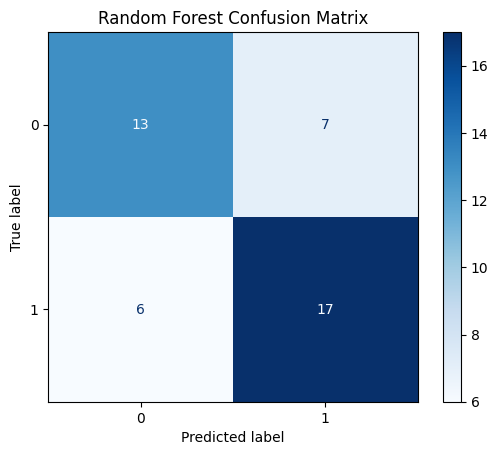

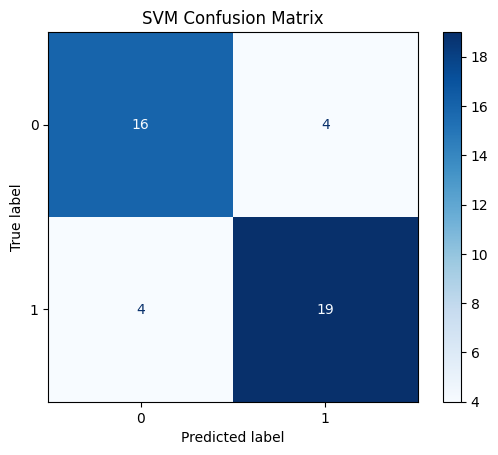

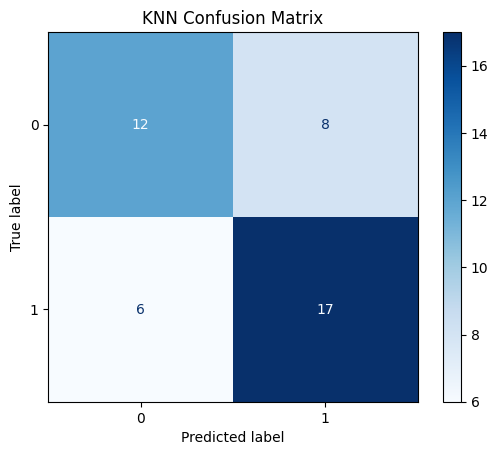

In [20]:
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap=plt.cm.Blues)
    plt.title(title)
    plt.show()

# Plot confusion matrix for Random Forest
plot_confusion_matrix(y_test, rf.predict(X_test), "Random Forest Confusion Matrix")
# Plot confusion matrix for SVM
plot_confusion_matrix(y_test, svm.predict(X_test), "SVM Confusion Matrix")
# Plot confusion matrix for KNN
plot_confusion_matrix(y_test, knn.predict(X_test), "KNN Confusion Matrix")